# Прогнозирование stock SBER

In [1]:
sym = 'SBERP'

### VWAP torch teacher_forcing

https://digitrain.ru/articles/310709/

In [2]:
%matplotlib inline

import glob
from platform import python_version
import pandas_ta as ta
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

import datetime
from datetime import datetime, date, timedelta

In [3]:
import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

In [4]:
dfs = pd.read_csv(f'{sym}_min.csv', index_col=0, parse_dates=True)
dfs

TICKER  PER      TIME    OPEN    HIGH     LOW   CLOSE  \
DATE                                                                        
2023-01-03 10:01:00  SBERP    1  10:01:00  141.39  141.98  141.35  141.77   
2023-01-03 10:02:00  SBERP    1  10:02:00  141.75  141.99  141.47  141.66   
2023-01-03 10:03:00  SBERP    1  10:03:00  141.58  141.66  141.58  141.64   
2023-01-03 10:04:00  SBERP    1  10:04:00  141.64  141.74  141.64  141.70   
2023-01-03 10:05:00  SBERP    1  10:05:00  141.68  141.78  141.66  141.72   
...                    ...  ...       ...     ...     ...     ...     ...   
2023-11-15 23:46:00  SBERP    1  23:46:00  281.69  281.69  281.69  281.69   
2023-11-15 23:47:00  SBERP    1  23:47:00  281.68  281.69  281.68  281.68   
2023-11-15 23:48:00  SBERP    1  23:48:00  281.69  281.69  281.69  281.69   
2023-11-15 23:49:00  SBERP    1  23:49:00  281.69  281.69  281.68  281.68   
2023-11-15 23:50:00  SBERP    1  23:50:00  281.69  281.69  281.34  281.49   

                       VOL  
DATE                        
2023-01-03 10:01:00  36870  
2023-01-03 10:02:00  20070  
2023-01-03 10:03:00   8280  
2023-01-03 10:04:00   3590  
2023-01-03 10:05:00   9030  
...                    ...  
2023-11-15 23:46:00     10  
2023-11-15 23:47:00    110  
2023-11-15 23:48:00    100  
2023-11-15 23:49:00    300  
2023-11-15 23:50:00   6860  

[176986 rows x 8 columns]

In [5]:
df_vwap = ta.vwap(dfs.HIGH, dfs.LOW, dfs.CLOSE, dfs.VOL, anchor = "5min")
df_vwap

DATE
2023-01-03 10:01:00    141.700000
2023-01-03 10:02:00    141.706667
2023-01-03 10:03:00    141.626667
2023-01-03 10:04:00    141.693333
2023-01-03 10:05:00    141.720000
                          ...    
2023-11-15 23:46:00    281.690000
2023-11-15 23:47:00    281.683333
2023-11-15 23:48:00    281.690000
2023-11-15 23:49:00    281.683333
2023-11-15 23:50:00    281.506667
Name: VWAP_5MIN, Length: 176986, dtype: float64

In [6]:
df_vwap.shape

(176986,)

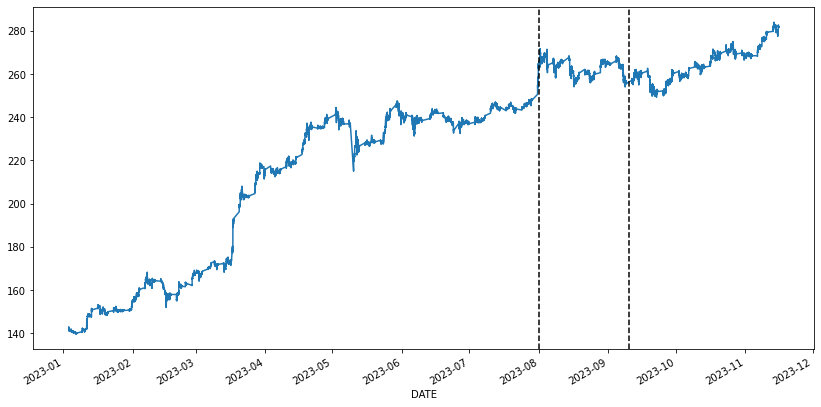

In [7]:
ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2023-08-01", linestyle="--", c="black")
ax.axvline("2023-09-10", linestyle="--", c="black")

In [8]:
df_train = df_vwap[df_vwap.index < "2023-08-01"].to_frame(name="vwap")
df_train.shape

(115812, 1)

In [9]:
df_val = df_vwap[(df_vwap.index >= "2023-08-01") & (df_vwap.index < "2023-09-10")].to_frame(name="vwap")
df_val.shape

(23219, 1)

In [10]:
df_test = df_vwap[df_vwap.index >= "2023-09-10"].to_frame(name='vwap')
df_test.shape

(37955, 1)

In [11]:
df_vwap[df_vwap.index >= "2023-09-10"].to_frame(name='vwap')

vwap
DATE                           
2023-09-11 10:01:00  257.030000
2023-09-11 10:02:00  257.706667
2023-09-11 10:03:00  257.660000
2023-09-11 10:04:00  257.130000
2023-09-11 10:05:00  256.676667
...                         ...
2023-11-15 23:46:00  281.690000
2023-11-15 23:47:00  281.683333
2023-11-15 23:48:00  281.690000
2023-11-15 23:49:00  281.683333
2023-11-15 23:50:00  281.506667

[37955 rows x 1 columns]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [13]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
#         print(x_i)
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
#         print(x)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [14]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [15]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

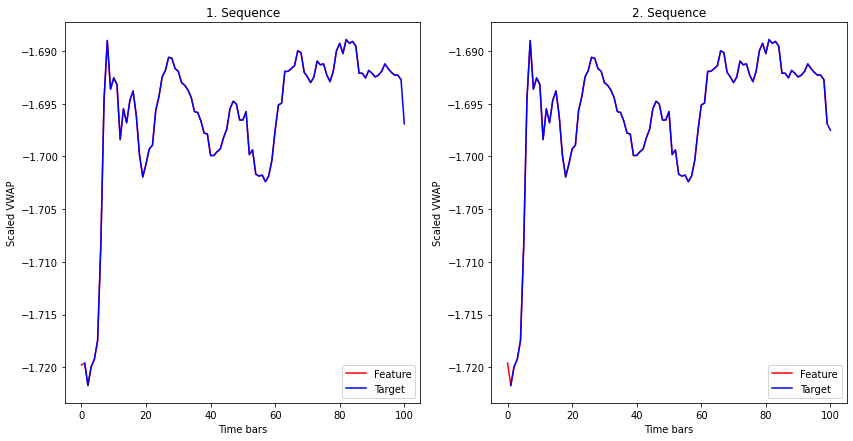

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [17]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
#         print('input', input)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
    
        
  
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]
        
         
        outputs = torch.stack(outputs, 1).squeeze(2)
      
        return outputs

In [18]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=10,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [19]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [20]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(np.array(df[col]).reshape(-1,1))
    return df

In [21]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [22]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.09. Validation loss: 0.09. Avg future: 0.00. Elapsed time: 102.49s.
Epoch 2 Train loss: 0.02. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 107.11s.
Epoch 3 Train loss: 0.02. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 117.29s.
Epoch 4 Train loss: 0.01. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 116.90s.
Epoch 5 Train loss: 0.00. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 111.02s.
Epoch 6 Train loss: 0.01. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 116.10s.
Epoch 7 Train loss: 0.00. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 110.55s.
Epoch 8 Train loss: 0.00. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 105.64s.
Epoch 9 Train loss: 0.00. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 106.69s.
Epoch 10 Train loss: 0.00. Validation loss: 0.00. Avg future: 0.00. Elapsed time: 105.17s.


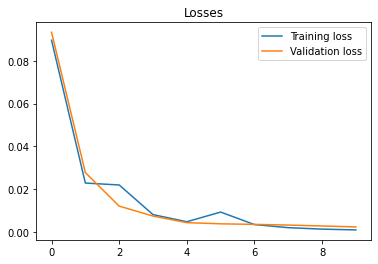

In [23]:
optimization_1.plot_losses()

Test loss 0.0021


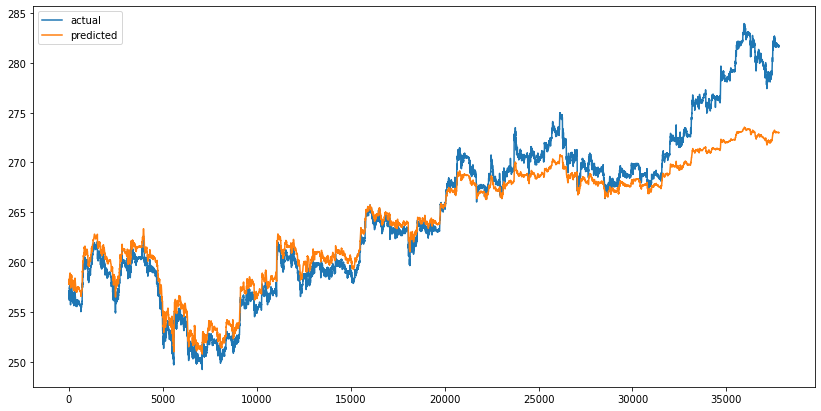

In [24]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
# df_result_1

df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

<Axes: >

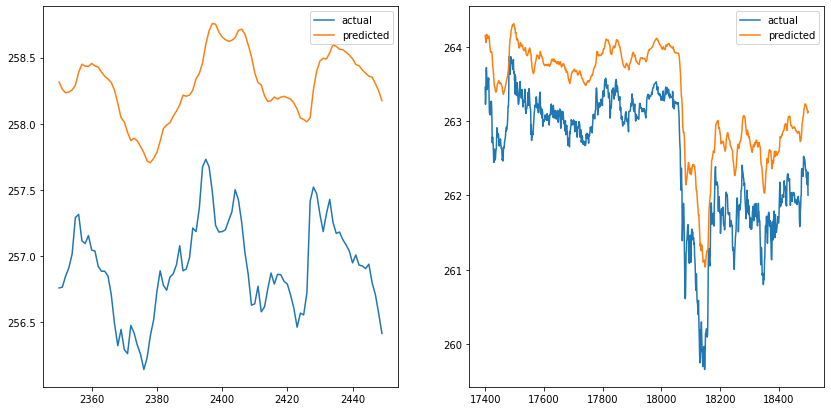

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[17400:18500].plot(ax=axes[1], figsize=(14, 7))

In [26]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

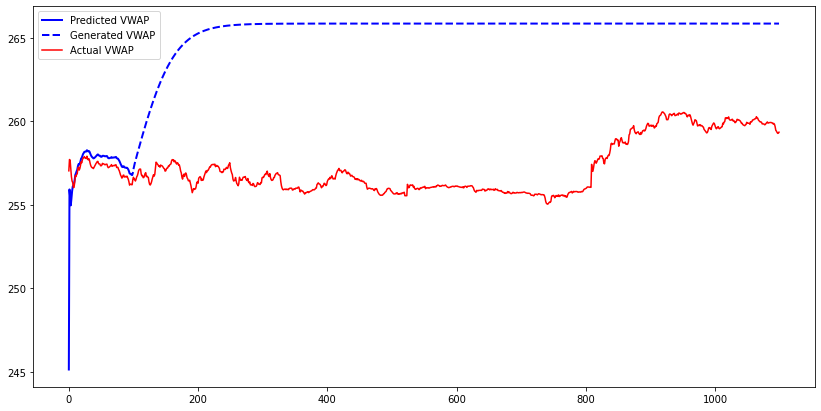

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

In [28]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)

In [29]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

Epoch 1 Train loss: 0.11. Validation loss: 0.09. Avg future: 24.83. Elapsed time: 115.82s.
Epoch 2 Train loss: 0.07. Validation loss: 0.08. Avg future: 25.73. Elapsed time: 109.50s.
Epoch 3 Train loss: 0.04. Validation loss: 0.02. Avg future: 25.61. Elapsed time: 109.43s.
Epoch 4 Train loss: 0.02. Validation loss: 0.01. Avg future: 25.41. Elapsed time: 153.84s.
Epoch 5 Train loss: 0.01. Validation loss: 0.01. Avg future: 25.57. Elapsed time: 171.18s.
Epoch 6 Train loss: 0.02. Validation loss: 0.01. Avg future: 25.20. Elapsed time: 155.60s.
Epoch 7 Train loss: 0.01. Validation loss: 0.01. Avg future: 25.20. Elapsed time: 106.03s.
Epoch 8 Train loss: 0.00. Validation loss: 0.01. Avg future: 26.26. Elapsed time: 106.51s.
Epoch 9 Train loss: 0.00. Validation loss: 0.01. Avg future: 25.01. Elapsed time: 109.15s.
Epoch 10 Train loss: 0.00. Validation loss: 0.01. Avg future: 24.73. Elapsed time: 121.88s.


Test loss 0.0077


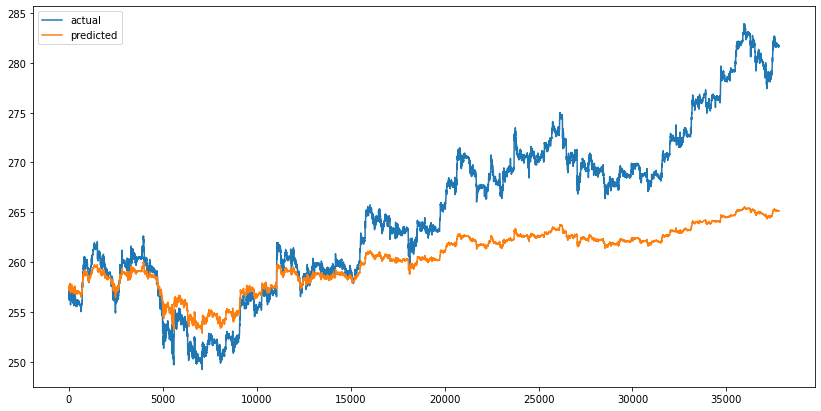

In [30]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

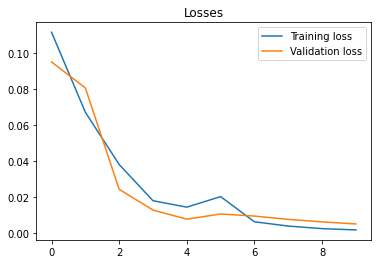

In [31]:
optimization_2.plot_losses()

<Axes: >

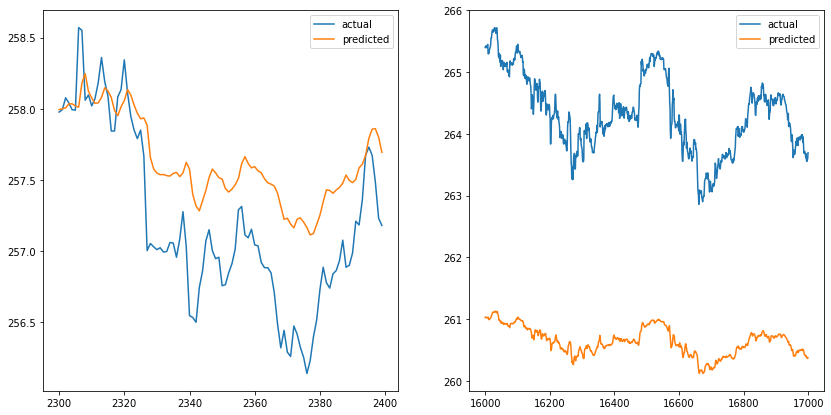

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[2300:2400].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[16000:17000].plot(ax=axes[1], figsize=(14, 7))

In [33]:
y_pred2 = generate_sequence(scaler, optimization_2.model, x_sample)

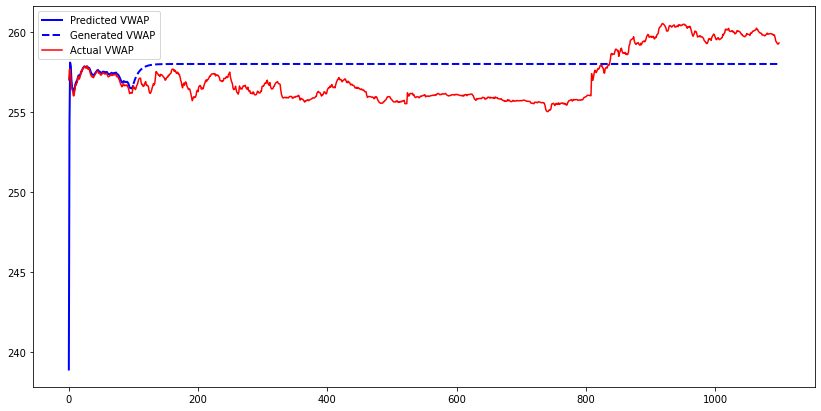

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred2[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred2[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

In [35]:
prices = dfs[['CLOSE']]
prices = scaler.fit_transform(prices)
prices = prices[-seq_len:]
prices = np.array(prices).reshape(-1, seq_len)
prices = torch.tensor(prices).float()

In [36]:
model_1.eval()

Model(
  (lstm): LSTMCell(1, 21)
  (linear): Linear(in_features=21, out_features=1, bias=True)
)

In [37]:
with torch.no_grad():
    prediction = model_1(prices)
    print(prediction.shape)
    print(prediction)
    
prediction = torch.squeeze(prediction[:, -1]).data.cpu().numpy().tolist()
predictions = scaler.inverse_transform(np.array(prediction).reshape(-1,1))[0][0]
print('Прогноз СБЕР VWAP_5min на', date.today(), '= ', round(predictions,3))

torch.Size([1, 100])
tensor([[1.0295, 1.3080, 1.2925, 1.2851, 1.3033, 1.3204, 1.3293, 1.3378, 1.3432,
         1.3471, 1.3490, 1.3514, 1.3516, 1.3538, 1.3549, 1.3546, 1.3552, 1.3566,
         1.3572, 1.3562, 1.3572, 1.3577, 1.3568, 1.3566, 1.3575, 1.3556, 1.3571,
         1.3577, 1.3567, 1.3565, 1.3564, 1.3563, 1.3559, 1.3557, 1.3575, 1.3577,
         1.3579, 1.3572, 1.3581, 1.3566, 1.3576, 1.3569, 1.3566, 1.3561, 1.3562,
         1.3551, 1.3559, 1.3562, 1.3564, 1.3568, 1.3576, 1.3580, 1.3582, 1.3583,
         1.3583, 1.3574, 1.3584, 1.3577, 1.3584, 1.3587, 1.3581, 1.3580, 1.3580,
         1.3580, 1.3580, 1.3580, 1.3579, 1.3578, 1.3579, 1.3578, 1.3579, 1.3577,
         1.3576, 1.3576, 1.3576, 1.3575, 1.3575, 1.3569, 1.3573, 1.3573, 1.3573,
         1.3566, 1.3570, 1.3571, 1.3570, 1.3567, 1.3565, 1.3568, 1.3569, 1.3570,
         1.3571, 1.3570, 1.3570, 1.3570, 1.3571, 1.3571, 1.3570, 1.3571, 1.3570,
         1.3548]])
Прогноз СБЕР VWAP_5min на 2023-11-16 =  282.129


In [38]:
model_2.eval()

Model(
  (lstm): LSTMCell(1, 21)
  (linear): Linear(in_features=21, out_features=1, bias=True)
)

In [39]:
with torch.no_grad():
    prediction = model_2(prices, future=5)
    
prediction = torch.squeeze(prediction[:, -5:]).numpy()
predictions = scaler.inverse_transform(prediction.reshape(-1,1))
predictions[:,0].tolist()

[281.8897399902344,
 281.99462890625,
 282.0938720703125,
 282.1831970214844,
 282.26287841796875]

In [40]:
with torch.no_grad():
    prediction = model_1(prices, future=5)
    
prediction = torch.squeeze(prediction[:, -5:]).numpy()
predictions = scaler.inverse_transform(prediction.reshape(-1,1))
predictions[:,0].tolist()

[282.3997497558594,
 282.62481689453125,
 282.8062438964844,
 282.9708251953125,
 283.1288757324219]

### RSI / EMA torch

https://lilynois.ru/use-lstm-models-to-predict-the-stock-market/

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import torch
import torch.nn as nn
import torch.optim as optim

In [42]:
# !pip3 install pandas_ta

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.backends.mps.is_available():
    device = torch.device('mps')

In [44]:
data = pd.read_csv('SBERP_day.csv', index_col=0, parse_dates=True)
data.tail(10)

TICKER PER  TIME    OPEN    HIGH     LOW   CLOSE      VOL
DATE                                                                
2023-11-02  SBERP   D     0  269.91  270.00  267.40  268.50  1575480
2023-11-03  SBERP   D     0  267.98  269.48  267.00  268.39  1369820
2023-11-06  SBERP   D     0  268.38  272.95  268.04  272.75  1781460
2023-11-07  SBERP   D     0  272.75  273.94  271.39  272.61  3045340
2023-11-08  SBERP   D     0  272.70  277.00  272.59  276.85  5029540
2023-11-09  SBERP   D     0  277.11  277.47  274.81  276.05  2706820
2023-11-10  SBERP   D     0  276.19  279.90  275.85  279.30  4346280
2023-11-13  SBERP   D     0  279.61  283.98  279.50  282.74  3733460
2023-11-14  SBERP   D     0  282.71  283.29  279.00  279.54  3607820
2023-11-15  SBERP   D     0  279.29  282.78  277.33  281.49  3225130

In [45]:
# data1 = yf.download(tickers = '^RUI', start = '2012-03-11',end = '2022-07-10')
# data1.tail(10)

In [46]:
# Adding indicators
data['RSI'] = ta.rsi(data.CLOSE, length=15)
data['EMAF'] = ta.ema(data.CLOSE, length=20)
data['EMAM'] = ta.ema(data.CLOSE, length=100)
data['EMAS'] = ta.ema(data.CLOSE, length=150)
data.tail(10)

TICKER PER  TIME    OPEN    HIGH     LOW   CLOSE      VOL  \
DATE                                                                   
2023-11-02  SBERP   D     0  269.91  270.00  267.40  268.50  1575480   
2023-11-03  SBERP   D     0  267.98  269.48  267.00  268.39  1369820   
2023-11-06  SBERP   D     0  268.38  272.95  268.04  272.75  1781460   
2023-11-07  SBERP   D     0  272.75  273.94  271.39  272.61  3045340   
2023-11-08  SBERP   D     0  272.70  277.00  272.59  276.85  5029540   
2023-11-09  SBERP   D     0  277.11  277.47  274.81  276.05  2706820   
2023-11-10  SBERP   D     0  276.19  279.90  275.85  279.30  4346280   
2023-11-13  SBERP   D     0  279.61  283.98  279.50  282.74  3733460   
2023-11-14  SBERP   D     0  282.71  283.29  279.00  279.54  3607820   
2023-11-15  SBERP   D     0  279.29  282.78  277.33  281.49  3225130   

                  RSI        EMAF        EMAM        EMAS  
DATE                                                       
2023-11-02  56.458563  267.012853  253.211643  241.986756  
2023-11-03  56.187056  267.144010  253.512204  242.336467  
2023-11-06  63.617289  267.677914  253.893151  242.739296  
2023-11-07  63.248266  268.147636  254.263781  243.134934  
2023-11-08  69.070077  268.976433  254.711033  243.581491  
2023-11-09  66.926851  269.650106  255.133587  244.011538  
2023-11-10  70.862265  270.569143  255.612130  244.478935  
2023-11-13  74.326717  271.728273  256.149315  244.985704  
2023-11-14  66.451892  272.472247  256.612497  245.443377  
2023-11-15  68.622410  273.331080  257.105121  245.920815

In [47]:
data['Target'] = data['CLOSE'] - data.OPEN
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['CLOSE'].shift(-1)
data.tail()

TICKER PER  TIME    OPEN    HIGH     LOW   CLOSE      VOL  \
DATE                                                                   
2023-11-09  SBERP   D     0  277.11  277.47  274.81  276.05  2706820   
2023-11-10  SBERP   D     0  276.19  279.90  275.85  279.30  4346280   
2023-11-13  SBERP   D     0  279.61  283.98  279.50  282.74  3733460   
2023-11-14  SBERP   D     0  282.71  283.29  279.00  279.54  3607820   
2023-11-15  SBERP   D     0  279.29  282.78  277.33  281.49  3225130   

                  RSI        EMAF        EMAM        EMAS  Target  \
DATE                                                                
2023-11-09  66.926851  269.650106  255.133587  244.011538    3.11   
2023-11-10  70.862265  270.569143  255.612130  244.478935    3.13   
2023-11-13  74.326717  271.728273  256.149315  244.985704   -3.17   
2023-11-14  66.451892  272.472247  256.612497  245.443377    2.20   
2023-11-15  68.622410  273.331080  257.105121  245.920815     NaN   

            TargetClass  TargetNextClose  
DATE                                      
2023-11-09            1           279.30  
2023-11-10            1           282.74  
2023-11-13            0           279.54  
2023-11-14            1           281.49  
2023-11-15            0              NaN

In [48]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['VOL', 'CLOSE', 'DATE', 'TICKER', 'PER', 'TIME' ], axis=1, inplace=True)
data_set = data.iloc[:, 0:11]
pd.set_option('display.max_columns', None)
data_set.tail()

OPEN    HIGH     LOW        RSI        EMAF        EMAM        EMAS  \
2566  272.70  277.00  272.59  69.070077  268.976433  254.711033  243.581491   
2567  277.11  277.47  274.81  66.926851  269.650106  255.133587  244.011538   
2568  276.19  279.90  275.85  70.862265  270.569143  255.612130  244.478935   
2569  279.61  283.98  279.50  74.326717  271.728273  256.149315  244.985704   
2570  282.71  283.29  279.00  66.451892  272.472247  256.612497  245.443377   

      Target  TargetClass  TargetNextClose  
2566   -1.06            0           276.05  
2567    3.11            1           279.30  
2568    3.13            1           282.74  
2569   -3.17            0           279.54  
2570    2.20            1           281.49

In [49]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.11168439 0.10805205 0.11446638 ... 0.76470588 1.         0.11137292]
 [0.11347763 0.10899491 0.11511163 ... 0.77833753 1.         0.11451461]
 [0.11372931 0.11172921 0.11740225 ... 0.76870648 1.         0.11589695]
 ...
 [0.7525011  0.75768433 0.77206736 ... 0.80989776 1.         0.76983977]
 [0.76326055 0.77050726 0.78384308 ... 0.7165506  0.         0.75978637]
 [0.77301328 0.76833868 0.78222997 ... 0.79611794 1.         0.76591266]]


In [50]:
X = []
backcandles = 30
print(data_set_scaled.shape)

for j in range(8):
    X.append([])
    
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i - backcandles:i, j])

(2571, 10)


In [51]:
X = np.moveaxis(X, [0], [2])

In [52]:
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])

In [53]:
y = np.reshape(yi, (len(yi), 1))

In [54]:
splitlimit = int(len(X) * 0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

In [55]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc1(out[:, -1, :])
        return out

In [56]:
input_dim = 8
hidden_dim = 150
num_layers = 1
output_dim = 1

In [57]:
modell = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterionn = nn.MSELoss()
optimizerr = optim.Adam(modell.parameters(), lr=0.01)

In [58]:
epochs = 30
losses = []

for epoch in range(epochs):
    optimizerr.zero_grad()
    outputs = modell(torch.Tensor(X_train))
    loss = criterionn(outputs, torch.Tensor(y_train))
    loss.backward()
    optimizerr.step()
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

Epoch [1/30], Loss: 0.1581
Epoch [6/30], Loss: 0.0136
Epoch [11/30], Loss: 0.0091
Epoch [16/30], Loss: 0.0020
Epoch [21/30], Loss: 0.0009
Epoch [26/30], Loss: 0.0010


In [59]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [60]:
with torch.no_grad():
    y_pred_tensor = modell(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy()

In [61]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE: {:.4f}, RMSE: {:.4f}'.format(mse, rmse))

MSE: 0.0048, RMSE: 0.0690


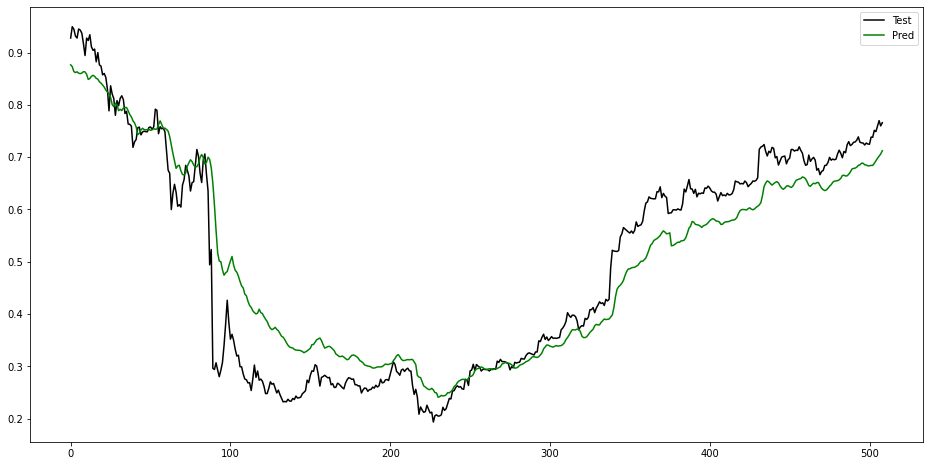

In [62]:
# Plot the results
plt.figure(figsize=(16,8))
plt.plot(y_test, color='black', label='Test')
plt.plot(y_pred, color='green', label='Pred')
plt.legend()
plt.show()

In [63]:
price = data_set[-backcandles:]
price = sc.fit_transform(price)

In [64]:
X1 = []
# backcandles = 30
print(price.shape)

for j in range(8):
    X1.append([])
    
    for i in range(price.shape[0]):
        X1[j].append(price[:, j])

(30, 10)


In [65]:
X1 = np.moveaxis(X1, [0], [2])
X1 = np.array(X1)
X1 = torch.Tensor(X1)

In [66]:
modell.eval()

LSTM(
  (lstm): LSTM(8, 150, batch_first=True)
  (fc1): Linear(in_features=150, out_features=1, bias=True)
)

In [67]:
with torch.no_grad():
    p = modell(X1)
p1 = p.numpy()

In [68]:
arr = np.zeros((30,9))

In [69]:
f= np.concatenate((arr, p1), axis=1)

In [70]:
pr = sc.inverse_transform(f)
ff = pr[:, -1 :][-1:][0][0]
print('Прогноз СБЕР на', date.today(), '= ', round(ff,3))

Прогноз СБЕР на 2023-11-16 =  279.518


### LinearRegression lag

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import datetime
from datetime import datetime, date, timedelta

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_csv('stock_day.csv')
df

DATE    GAZP    ROSN   SBERP  RTKMP    MOEX
0     2013-01-08  147.90  268.98   70.38  92.50     NaN
1     2013-01-09  148.91  268.99   70.69  92.03     NaN
2     2013-01-10  147.60  266.65   70.90  91.00     NaN
3     2013-01-11  147.97  265.28   71.32  90.01     NaN
4     2013-01-14  149.60  267.00   72.47  90.56     NaN
...          ...     ...     ...     ...    ...     ...
2716  2023-11-09  168.16  583.10  276.05  74.10  205.11
2717  2023-11-10  168.25  598.30  279.30  74.30  211.10
2718  2023-11-13  167.85  598.30  282.74  76.35  202.49
2719  2023-11-14  165.86  591.30  279.54  75.80  198.41
2720  2023-11-15  166.46  585.00  281.49  76.35  202.79

[2721 rows x 6 columns]

In [73]:
y = 'y'
dat = 'ds'

In [74]:
dfs = pd.read_csv('stock_day.csv', index_col=0, parse_dates=True)
dfs = dfs.rename(columns={sym: y})
dfs.index.names = [dat]
dfs

GAZP    ROSN       y  RTKMP    MOEX
ds                                               
2013-01-08  147.90  268.98   70.38  92.50     NaN
2013-01-09  148.91  268.99   70.69  92.03     NaN
2013-01-10  147.60  266.65   70.90  91.00     NaN
2013-01-11  147.97  265.28   71.32  90.01     NaN
2013-01-14  149.60  267.00   72.47  90.56     NaN
...            ...     ...     ...    ...     ...
2023-11-09  168.16  583.10  276.05  74.10  205.11
2023-11-10  168.25  598.30  279.30  74.30  211.10
2023-11-13  167.85  598.30  282.74  76.35  202.49
2023-11-14  165.86  591.30  279.54  75.80  198.41
2023-11-15  166.46  585.00  281.49  76.35  202.79

[2721 rows x 5 columns]

In [75]:
dfs1 = dfs[['y']]
dfs1.sort_index(inplace=True)
print('Монотонность - ',dfs1.index.is_monotonic)

Монотонность -  True


In [76]:
dfs1

y
ds                
2013-01-08   70.38
2013-01-09   70.69
2013-01-10   70.90
2013-01-11   71.32
2013-01-14   72.47
...            ...
2023-11-09  276.05
2023-11-10  279.30
2023-11-13  282.74
2023-11-14  279.54
2023-11-15  281.49

[2721 rows x 1 columns]

<Axes: xlabel='ds'>

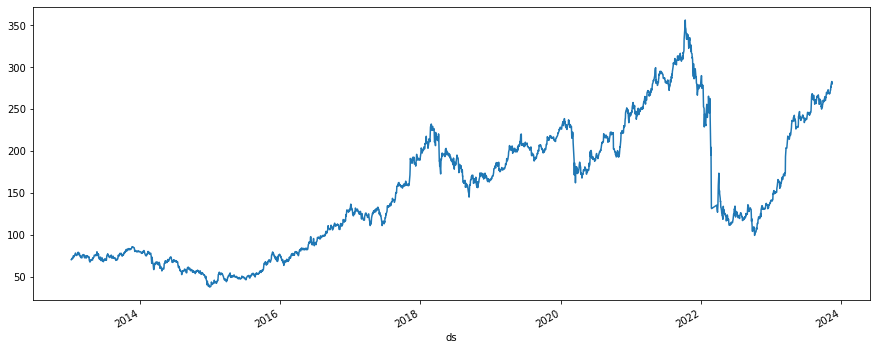

In [77]:
dfs1.y.plot(figsize=(15,6))

<Axes: xlabel='ds'>

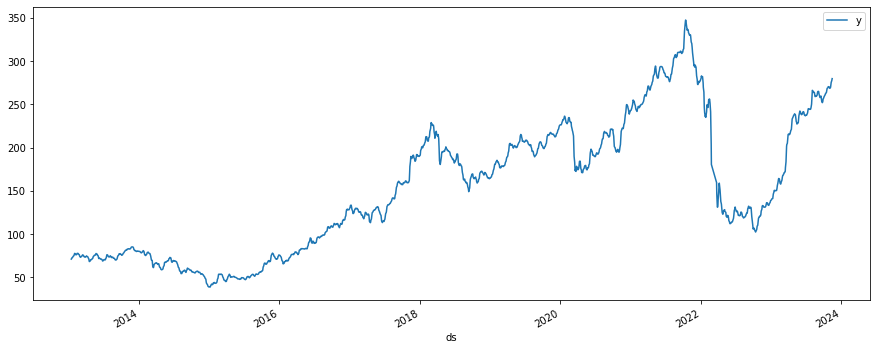

In [78]:
dfs1.rolling(5).mean().plot(figsize=(15,6))

In [79]:
# функция по созданию сгенерированных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['y'].shift(lag)

    data['y_mean'] = data['y'].shift().rolling(rolling_mean_size).mean().copy()
    
    return data

In [80]:
dfs11 = make_features(dfs1, 7, 3)
dfs11.dropna(inplace=True)
dfs11

y  year  month  day  dayofweek  is_weekend   lag_1   lag_2  \
ds                                                                            
2013-01-17   72.91  2013      1   17          3           0   72.10   71.50   
2013-01-18   74.68  2013      1   18          4           0   72.91   72.10   
2013-01-21   74.77  2013      1   21          0           0   74.68   72.91   
2013-01-22   73.59  2013      1   22          1           0   74.77   74.68   
2013-01-23   75.04  2013      1   23          2           0   73.59   74.77   
...            ...   ...    ...  ...        ...         ...     ...     ...   
2023-11-09  276.05  2023     11    9          3           0  276.85  272.61   
2023-11-10  279.30  2023     11   10          4           0  276.05  276.85   
2023-11-13  282.74  2023     11   13          0           0  279.30  276.05   
2023-11-14  279.54  2023     11   14          1           0  282.74  279.30   
2023-11-15  281.49  2023     11   15          2           0  279.54  282.74   

             lag_3   lag_4   lag_5   lag_6   lag_7      y_mean  
ds                                                              
2013-01-17   72.47   71.32   70.90   70.69   70.38   72.023333  
2013-01-18   71.50   72.47   71.32   70.90   70.69   72.170000  
2013-01-21   72.10   71.50   72.47   71.32   70.90   73.230000  
2013-01-22   72.91   72.10   71.50   72.47   71.32   74.120000  
2013-01-23   74.68   72.91   72.10   71.50   72.47   74.346667  
...            ...     ...     ...     ...     ...         ...  
2023-11-09  272.75  268.39  268.50  269.12  267.93  274.070000  
2023-11-10  272.61  272.75  268.39  268.50  269.12  275.170000  
2023-11-13  276.85  272.61  272.75  268.39  268.50  277.400000  
2023-11-14  276.05  276.85  272.61  272.75  268.39  279.363333  
2023-11-15  279.30  276.05  276.85  272.61  272.75  280.526667  

[2714 rows x 14 columns]

In [81]:
features = dfs11.drop(['y'],axis = 1)
target = dfs11['y']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.25)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (2035, 13)
X_test (679, 13)


In [82]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

LinearRegression()

In [83]:
y_predicted_lr = model_lr.predict(X_test)
# y_predicted_lr

In [84]:
df1_with_predict = X_test
df1_with_predict['y'] = y_test
df1_with_predict['y_predicted_lr'] = y_predicted_lr
df1_with_predict[['y','y_predicted_lr']]

y  y_predicted_lr
ds                                
2021-02-18  247.00      248.277128
2021-02-19  249.64      247.226744
2021-02-20  249.12      249.559997
2021-02-22  251.48      249.010044
2021-02-24  250.26      251.371975
...            ...             ...
2023-11-09  276.05      277.101789
2023-11-10  279.30      276.574399
2023-11-13  282.74      279.904804
2023-11-14  279.54      283.313999
2023-11-15  281.49      279.846916

[679 rows x 2 columns]

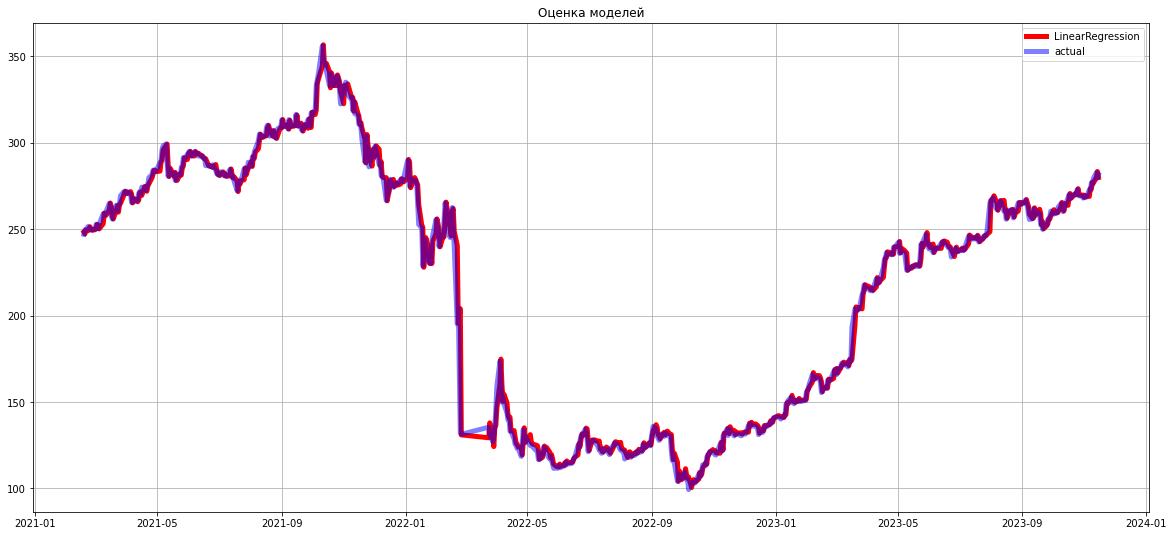

In [85]:
plt.figure(figsize=(20, 9))
plt.plot(df1_with_predict['y_predicted_lr'], "r",linewidth=5, label="LinearRegression")
plt.plot(df1_with_predict['y'],'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True);

In [86]:
# Посчитаем ошибки модели
print('RMSE тестовой выборки LinearRegression: ', np.sqrt(mean_squared_error(y_test, y_predicted_lr)))
print('MAE тестовой выборки Linear Regression: ', mean_absolute_error(y_test, y_predicted_lr))

RMSE тестовой выборки LinearRegression:  5.2071180504279315
MAE тестовой выборки Linear Regression:  2.9460140730686932


In [87]:
# Добавим в данные на завтра и предскажем курс акции в этот день
dfap = dfs[['y']].tail(1).copy()
dfap['y'] = 0
dfap = dfap.reset_index()
# dfap['ds'] = dfap['ds'] + timedelta(days=1)
dfap['ds'] = date.today()
dfap['ds'] = pd.to_datetime(dfap['ds'], infer_datetime_format=True)
dfap.set_index('ds', drop=True, inplace=True)

df_new = dfs[['y']].append(dfap)
df_new

y
ds                
2013-01-08   70.38
2013-01-09   70.69
2013-01-10   70.90
2013-01-11   71.32
2013-01-14   72.47
...            ...
2023-11-10  279.30
2023-11-13  282.74
2023-11-14  279.54
2023-11-15  281.49
2023-11-16    0.00

[2722 rows x 1 columns]

In [88]:
make_features(df_new, 7, 3)
df_new.dropna(inplace=True)
df_new

y  year  month  day  dayofweek  is_weekend   lag_1   lag_2  \
ds                                                                            
2013-01-17   72.91  2013      1   17          3           0   72.10   71.50   
2013-01-18   74.68  2013      1   18          4           0   72.91   72.10   
2013-01-21   74.77  2013      1   21          0           0   74.68   72.91   
2013-01-22   73.59  2013      1   22          1           0   74.77   74.68   
2013-01-23   75.04  2013      1   23          2           0   73.59   74.77   
...            ...   ...    ...  ...        ...         ...     ...     ...   
2023-11-10  279.30  2023     11   10          4           0  276.05  276.85   
2023-11-13  282.74  2023     11   13          0           0  279.30  276.05   
2023-11-14  279.54  2023     11   14          1           0  282.74  279.30   
2023-11-15  281.49  2023     11   15          2           0  279.54  282.74   
2023-11-16    0.00  2023     11   16          3           0  281.49  279.54   

             lag_3   lag_4   lag_5   lag_6   lag_7      y_mean  
ds                                                              
2013-01-17   72.47   71.32   70.90   70.69   70.38   72.023333  
2013-01-18   71.50   72.47   71.32   70.90   70.69   72.170000  
2013-01-21   72.10   71.50   72.47   71.32   70.90   73.230000  
2013-01-22   72.91   72.10   71.50   72.47   71.32   74.120000  
2013-01-23   74.68   72.91   72.10   71.50   72.47   74.346667  
...            ...     ...     ...     ...     ...         ...  
2023-11-10  272.61  272.75  268.39  268.50  269.12  275.170000  
2023-11-13  276.85  272.61  272.75  268.39  268.50  277.400000  
2023-11-14  276.05  276.85  272.61  272.75  268.39  279.363333  
2023-11-15  279.30  276.05  276.85  272.61  272.75  280.526667  
2023-11-16  282.74  279.30  276.05  276.85  272.61  281.256667  

[2715 rows x 14 columns]

In [89]:
X_test1 = df_new.drop(['y'],axis = 1)
X_test1

year  month  day  dayofweek  is_weekend   lag_1   lag_2   lag_3  \
ds                                                                            
2013-01-17  2013      1   17          3           0   72.10   71.50   72.47   
2013-01-18  2013      1   18          4           0   72.91   72.10   71.50   
2013-01-21  2013      1   21          0           0   74.68   72.91   72.10   
2013-01-22  2013      1   22          1           0   74.77   74.68   72.91   
2013-01-23  2013      1   23          2           0   73.59   74.77   74.68   
...          ...    ...  ...        ...         ...     ...     ...     ...   
2023-11-10  2023     11   10          4           0  276.05  276.85  272.61   
2023-11-13  2023     11   13          0           0  279.30  276.05  276.85   
2023-11-14  2023     11   14          1           0  282.74  279.30  276.05   
2023-11-15  2023     11   15          2           0  279.54  282.74  279.30   
2023-11-16  2023     11   16          3           0  281.49  279.54  282.74   

             lag_4   lag_5   lag_6   lag_7      y_mean  
ds                                                      
2013-01-17   71.32   70.90   70.69   70.38   72.023333  
2013-01-18   72.47   71.32   70.90   70.69   72.170000  
2013-01-21   71.50   72.47   71.32   70.90   73.230000  
2013-01-22   72.10   71.50   72.47   71.32   74.120000  
2013-01-23   72.91   72.10   71.50   72.47   74.346667  
...            ...     ...     ...     ...         ...  
2023-11-10  272.75  268.39  268.50  269.12  275.170000  
2023-11-13  272.61  272.75  268.39  268.50  277.400000  
2023-11-14  276.85  272.61  272.75  268.39  279.363333  
2023-11-15  276.05  276.85  272.61  272.75  280.526667  
2023-11-16  279.30  276.05  276.85  272.61  281.256667  

[2715 rows x 13 columns]

In [90]:
yy = model_lr.predict(X_test1)
yy

array([ 71.73913401,  72.62309967,  74.4956634 , ..., 283.3139985 ,
       279.84691574, 281.633917  ])

In [91]:
len(yy)

2715

In [92]:
print('Прогноз СБЕР на', date.today(), '= ', round(yy[-1:][0],3))

Прогноз СБЕР на 2023-11-16 =  281.634


## Используем Facebok

In [93]:
# https://facebook.github.io/prophet/
from prophet import Prophet

In [94]:
df_prophet = dfs[['y']]
df_prophet = df_prophet.reset_index()
df_prophet

ds       y
0    2013-01-08   70.38
1    2013-01-09   70.69
2    2013-01-10   70.90
3    2013-01-11   71.32
4    2013-01-14   72.47
...         ...     ...
2716 2023-11-09  276.05
2717 2023-11-10  279.30
2718 2023-11-13  282.74
2719 2023-11-14  279.54
2720 2023-11-15  281.49

[2721 rows x 2 columns]

In [95]:
m = Prophet()

In [96]:
m.add_country_holidays(country_name='RU')
m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [97]:
future = m.make_future_dataframe(periods=7)
future.tail(7)

ds
2721 2023-11-16
2722 2023-11-17
2723 2023-11-18
2724 2023-11-19
2725 2023-11-20
2726 2023-11-21
2727 2023-11-22

In [98]:
forecast = m.predict(future)
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2013-01-08   81.052475   39.131092  130.039761    81.052475    81.052475   
1    2013-01-09   81.014684   38.949639  129.985132    81.014684    81.014684   
2    2013-01-10   80.976893   38.368418  127.683250    80.976893    80.976893   
3    2013-01-11   80.939102   36.217111  127.091994    80.939102    80.939102   
4    2013-01-14   80.825729   37.870840  129.781160    80.825729    80.825729   
...         ...         ...         ...         ...          ...          ...   
2723 2023-11-18  184.310908  146.413487  237.181079   184.310908   184.310908   
2724 2023-11-19  184.247248  137.245192  227.418675   184.247248   184.247248   
2725 2023-11-20  184.183587  143.838163  237.134913   184.183587   184.183587   
2726 2023-11-21  184.119926  143.276788  235.515794   184.119926   184.119926   
2727 2023-11-22  184.056266  145.224539  231.998632   184.056266   184.056266   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0               0.0                  0.0                  0.0   
1               0.0                  0.0                  0.0   
2               0.0                  0.0                  0.0   
3               0.0                  0.0                  0.0   
4               0.0                  0.0                  0.0   
...             ...                  ...                  ...   
2723            0.0                  0.0                  0.0   
2724            0.0                  0.0                  0.0   
2725            0.0                  0.0                  0.0   
2726            0.0                  0.0                  0.0   
2727            0.0                  0.0                  0.0   

      Defender of the Fatherland Day  Defender of the Fatherland Day_lower  \
0                                0.0                                   0.0   
1                                0.0                                   0.0   
2                                0.0                                   0.0   
3                                0.0                                   0.0   
4                                0.0                                   0.0   
...                              ...                                   ...   
2723                             0.0                                   0.0   
2724                             0.0                                   0.0   
2725                             0.0                                   0.0   
2726                             0.0                                   0.0   
2727                             0.0                                   0.0   

      Defender of the Fatherland Day_upper  International Women's Day  \
0                                      0.0                        0.0   
1                                      0.0                        0.0   
2                                      0.0                        0.0   
3                                      0.0                        0.0   
4                                      0.0                        0.0   
...                                    ...                        ...   
2723                                   0.0                        0.0   
2724                                   0.0                        0.0   
2725                                   0.0                        0.0   
2726                                   0.0                        0.0   
2727                                   0.0                        0.0   

      International Women's Day_lower  International Women's Day_upper  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   
.

In [99]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]#.tail(15)

ds        yhat  yhat_lower  yhat_upper
0    2013-01-08   83.872484   39.131092  130.039761
1    2013-01-09   83.998941   38.949639  129.985132
2    2013-01-10   82.865956   38.368418  127.683250
3    2013-01-11   83.005583   36.217111  127.091994
4    2013-01-14   83.531721   37.870840  129.781160
...         ...         ...         ...         ...
2723 2023-11-18  192.538029  146.413487  237.181079
2724 2023-11-19  184.676420  137.245192  227.418675
2725 2023-11-20  190.977331  143.838163  237.134913
2726 2023-11-21  190.330925  143.276788  235.515794
2727 2023-11-22  190.105255  145.224539  231.998632

[2728 rows x 4 columns]

In [100]:
forecast.set_index('ds', inplace=True)

<Axes: xlabel='ds'>

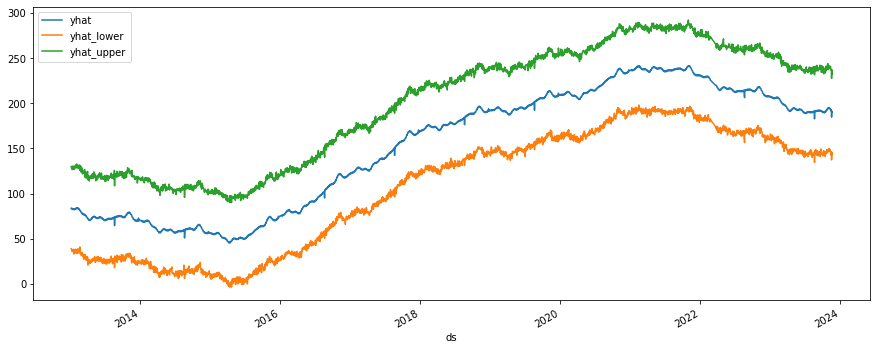

In [101]:
forecast[[ 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(15,6))

In [102]:
print("RMSE on Prophet: ",np.sqrt(mean_squared_error(dfs['y'], forecast.yhat[:-7])))

RMSE on Prophet:  36.18537440748545


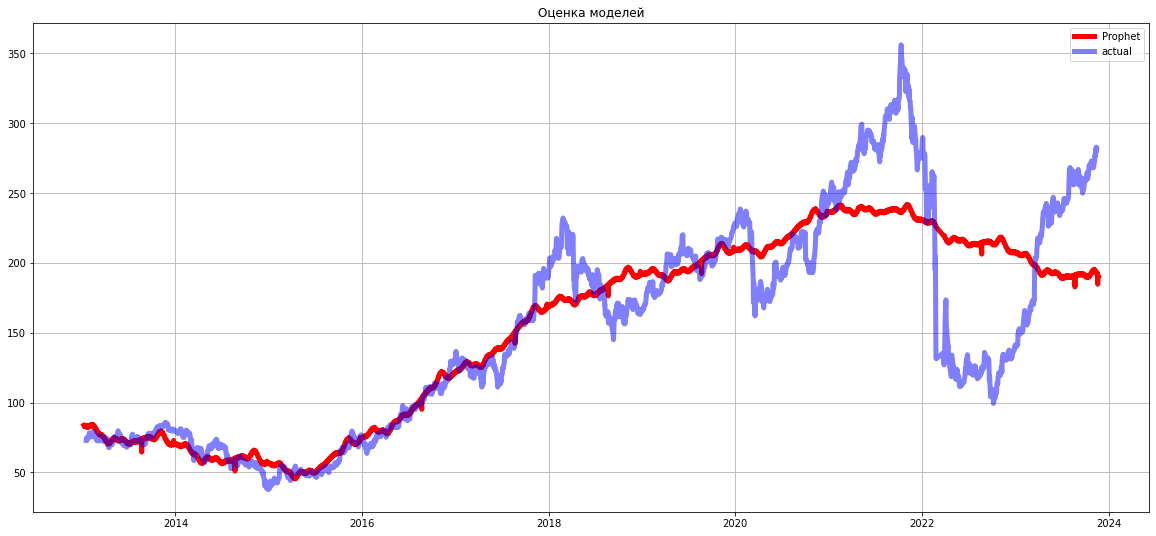

In [103]:
plt.figure(figsize=(20, 9))
plt.plot(forecast['yhat'], "r",linewidth=5, label="Prophet")
plt.plot(dfs1['y'],'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True);

#### Сравниваем результаты

In [104]:
len(yy)

2715

In [105]:
df1_with_predict = X_test1.tail(1000)
df1_with_predict['y'] = y_test.tail(1000)
df1_with_predict['y_predicted_lr'] = yy[-1000:]
df1_with_predict['y_prophet'] = forecast.yhat[-1000:]
df1_with_predict[['y','y_predicted_lr', 'y_prophet']]

y  y_predicted_lr   y_prophet
ds                                            
2019-11-07     NaN      216.853228         NaN
2019-11-08     NaN      218.304354         NaN
2019-11-11     NaN      218.012460         NaN
2019-11-12     NaN      217.921047         NaN
2019-11-13     NaN      217.669177         NaN
...            ...             ...         ...
2023-11-10  279.30      276.574399  193.802217
2023-11-13  282.74      279.904804  193.779092
2023-11-14  279.54      283.313999  193.232428
2023-11-15  281.49      279.846916  193.077647
2023-11-16     NaN      281.633917  191.644823

[1000 rows x 3 columns]

<Axes: xlabel='ds'>

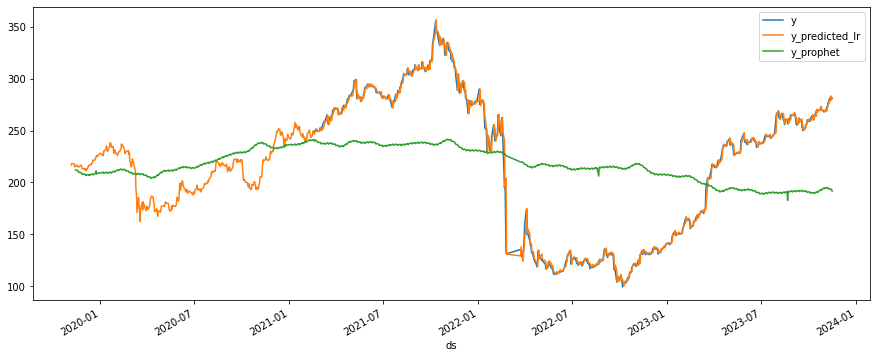

In [106]:
df1_with_predict[[ 'y', 'y_predicted_lr', 'y_prophet']].plot(figsize=(15,6))

# NeuralProphet

https://github.com/ourownstory/neural_prophet

In [107]:
from neuralprophet import NeuralProphet

In [108]:
df_np = dfs[["y"]]
df_np = df_np.reset_index()
df_np

ds       y
0    2013-01-08   70.38
1    2013-01-09   70.69
2    2013-01-10   70.90
3    2013-01-11   71.32
4    2013-01-14   72.47
...         ...     ...
2716 2023-11-09  276.05
2717 2023-11-10  279.30
2718 2023-11-13  282.74
2719 2023-11-14  279.54
2720 2023-11-15  281.49

[2721 rows x 2 columns]

In [109]:
df_np.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2721 non-null   datetime64[ns]
 1   y       2721 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.6 KB


In [110]:
m_np = NeuralProphet()

In [111]:
m_np.add_country_holidays(country_name='RU')

In [112]:
m_np.fit(df_np, freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.876% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 

Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

MAE        RMSE      Loss  RegLoss  epoch
0    281.442627  342.333740  0.617375      0.0      0
1    262.687317  321.146118  0.555002      0.0      1
2    246.576355  301.298431  0.506359      0.0      2
3    221.324326  271.615753  0.427662      0.0      3
4    189.255615  232.742874  0.330635      0.0      4
..          ...         ...       ...      ...    ...
140   24.119049   35.848007  0.010555      0.0    140
141   24.000111   35.721443  0.010535      0.0    141
142   23.967367   35.777893  0.010529      0.0    142
143   24.331776   36.053791  0.010594      0.0    143
144   24.039400   35.799767  0.010526      0.0    144

[145 rows x 5 columns]

In [113]:
future_np = m_np.make_future_dataframe(df_np, periods=7)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.876% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [114]:
forecast_np = m_np.predict(future_np)
forecast_np

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 86it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


ds     y       yhat1       trend  season_yearly  season_weekly  \
0 2023-11-16  None  195.620193  186.121414       8.464076       1.034693   
1 2023-11-17  None  196.451859  186.066528       8.210502       2.174823   
2 2023-11-18  None  197.973770  186.011612       7.933427       4.028733   
3 2023-11-19  None  177.924271  185.956680       7.634718     -15.667147   
4 2023-11-20  None  195.519882  185.901764       7.316387       2.301730   
5 2023-11-21  None  196.428116  185.846878       6.980570       3.600668   
6 2023-11-22  None  194.947968  185.791946       6.629518       2.526499   

   events_additive  event_День Победы  event_День России  \
0              0.0                0.0                0.0   
1              0.0                0.0                0.0   
2              0.0                0.0                0.0   
3              0.0                0.0                0.0   
4              0.0                0.0                0.0   
5              0.0                0.0                0.0   
6              0.0                0.0                0.0   

   event_День защитника Отечества  event_День народного единства  \
0                             0.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             0.0                            0.0   
4                             0.0                            0.0   
5                             0.0                            0.0   
6                             0.0                            0.0   

   event_Международный женский день  event_Новогодние каникулы  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3                               0.0                        0.0   
4                               0.0                        0.0   
5                               0.0                        0.0   
6                               0.0                        0.0   

   event_Праздник Весны и Труда  event_Рождество Христово  
0                           0.0                       0.0  
1                           0.0                       0.0  
2                           0.0                       0.0  
3                           0.0                       0.0  
4                           0.0                       0.0  
5                           0.0                       0.0  
6                           0.0                       0.0

In [115]:
fig_forecast = m_np.plot(forecast_np)
fig_components = m_np.plot_components(forecast_np)
fig_model = m_np.plot_parameters()

In [116]:
fig_forecast 

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'da6491b2-f5e6-4f9b-898f-b21918db443f',
              'x': array([datetime.datetime(2023, 11, 16, 0, 0),
                          datetime.datetime(2023, 11, 17, 0, 0),
                          datetime.datetime(2023, 11, 18, 0, 0),
                          datetime.datetime(2023, 11, 19, 0, 0),
                          datetime.datetime(2023, 11, 20, 0, 0),
                          datetime.datetime(2023, 11, 21, 0, 0),
                          datetime.datetime(2023, 11, 22, 0, 0)], dtype=object),
              'y': array([195.62019348, 196.45185852, 197.97377014, 177.92427063, 195.5198822 ,
                          196.42811584, 194.94796753])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
      

In [117]:
fig_components

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'showlegend': False,
              'type': 'scatter',
              'uid': '9cf4ac3f-7d60-4bee-8422-ed4c7aff6f14',
              'x': array([datetime.datetime(2023, 11, 16, 0, 0),
                          datetime.datetime(2023, 11, 17, 0, 0),
                          datetime.datetime(2023, 11, 18, 0, 0),
                          datetime.datetime(2023, 11, 19, 0, 0),
                          datetime.datetime(2023, 11, 20, 0, 0),
                          datetime.datetime(2023, 11, 21, 0, 0),
                          datetime.datetime(2023, 11, 22, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([186.12141418, 186.06652832, 186.01161194, 185.9566803 , 185.90176392,
                          185.84687805, 185.79194641]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'width

In [118]:
fig_model

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~4D</i>',
              'type': 'scatter',
              'uid': '6e658bcd-bfd0-4544-a3b1-179e92e0f6c9',
              'x': array([datetime.datetime(2013, 1, 8, 0, 0),
                          datetime.datetime(2013, 1, 9, 0, 0),
                          datetime.datetime(2013, 1, 13, 0, 0), ...,
                          datetime.datetime(2023, 11, 9, 0, 0),
                          datetime.datetime(2023, 11, 11, 0, 0),
                          datetime.datetime(2023, 11, 15, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 73.57102609,  73.57225151,  73.57715322, ..., 186.50584453,
                          186.39601324, 186.17635064]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              

In [119]:
forecastnp = m_np.predict(df_np)
forecastnp

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.876% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.876% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 86it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


ds       y       yhat1       trend  season_yearly  season_weekly  \
0    2013-01-08   70.38   78.041367   73.571030       1.652051       3.600668   
1    2013-01-09   70.69   77.881554   73.572250       1.782803       2.526499   
2    2013-01-10   70.90   76.514313   73.573479       1.906141       1.034693   
3    2013-01-11   71.32   77.770935   73.574707       2.021405       2.174823   
4    2013-01-14   72.47   78.194092   73.578384       2.313979       2.301730   
...         ...     ...         ...         ...            ...            ...   
2716 2023-11-09  276.05  197.001892  186.505844       9.461350       1.034693   
2717 2023-11-10  279.30  198.035141  186.450912       9.409399       2.174823   
2718 2023-11-13  282.74  197.655533  186.286179       9.067610       2.301730   
2719 2023-11-14  279.54  198.725998  186.231262       8.894067       3.600668   
2720 2023-11-15  281.49  197.395279  186.176346       8.692441       2.526499   

      events_additive  event_День Победы  event_День России  \
0           -0.782381                0.0                0.0   
1            0.000000                0.0                0.0   
2            0.000000                0.0                0.0   
3            0.000000                0.0                0.0   
4            0.000000                0.0                0.0   
...               ...                ...                ...   
2716         0.000000                0.0                0.0   
2717         0.000000                0.0                0.0   
2718         0.000000                0.0                0.0   
2719         0.000000                0.0                0.0   
2720         0.000000                0.0                0.0   

      event_День защитника Отечества  event_День народного единства  \
0                                0.0                            0.0   
1                                0.0                            0.0   
2                                0.0                            0.0   
3                                0.0                            0.0   
4                                0.0                            0.0   
...                              ...                            ...   
2716                             0.0                            0.0   
2717                             0.0                            0.0   
2718                             0.0                            0.0   
2719                             0.0                            0.0   
2720                             0.0                            0.0   

      event_Международный женский день  event_Новогодние каникулы  \
0                                  0.0                  -0.782381   
1                                  0.0                   0.000000   
2                                  0.0                   0.000000   
3                                  0.0                   0.000000   
4                                  0.0                   0.000000   
...                                ...                        ...   
2716                               0.0                   0.000000   
2717                               0.0                   0.000000   
2718                               0.0                   0.000000   
2719                               0.0                   0.000000   
2720                               0.0                   0.000000   

      event_Праздник Весны и Труда  event_Рождество Христово  
0                              0.0                       0.0  
1                              0.0                       0.0  
2                              0.0                       0.0  
3                              0.0                       0.0  
4                              0.0                       0.0  
...                            ...                       ...  
2716                           0.0                       0.0  
2717                           0.0                       0.0  
2718                           0.0

In [120]:
fig_forecast1 = m_np.plot(forecastnp)
fig_components1 = m_np.plot_components(forecastnp)
fig_model1 = m_np.plot_parameters()

In [121]:
fig_forecast1

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~4D</i>',
              'type': 'scatter',
              'uid': '1e36278a-7f32-4844-bc90-aaa0de4cddeb',
              'x': array([datetime.datetime(2013, 1, 8, 0, 0),
                          datetime.datetime(2013, 1, 10, 0, 0),
                          datetime.datetime(2013, 1, 15, 0, 0), ...,
                          datetime.datetime(2023, 11, 7, 0, 0),
                          datetime.datetime(2023, 11, 14, 0, 0),
                          datetime.datetime(2023, 11, 15, 0, 0)], dtype=object),
              'y': array([ 78.04136658,  76.51431274,  79.57304382, ..., 199.68675232,
                          198.72599792, 197.39527893])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
           

In [122]:
fig_components1

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~4D</i>',
              'showlegend': False,
              'type': 'scatter',
              'uid': '13bcdd9a-843b-44b7-9557-c6c28ff5aa9a',
              'x': array([datetime.datetime(2013, 1, 8, 0, 0),
                          datetime.datetime(2013, 1, 9, 0, 0),
                          datetime.datetime(2013, 1, 14, 0, 0), ...,
                          datetime.datetime(2023, 11, 9, 0, 0),
                          datetime.datetime(2023, 11, 10, 0, 0),
                          datetime.datetime(2023, 11, 15, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 73.57102966,  73.57225037,  73.5783844 , ..., 186.50584412,
                          186.45091248, 186.17634583]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'width': 2},

In [123]:
fig_model1

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~4D</i>',
              'type': 'scatter',
              'uid': '19087014-c270-4a02-b295-9a79e786c8e6',
              'x': array([datetime.datetime(2013, 1, 8, 0, 0),
                          datetime.datetime(2013, 1, 9, 0, 0),
                          datetime.datetime(2013, 1, 13, 0, 0), ...,
                          datetime.datetime(2023, 11, 9, 0, 0),
                          datetime.datetime(2023, 11, 11, 0, 0),
                          datetime.datetime(2023, 11, 15, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 73.57102609,  73.57225151,  73.57715322, ..., 186.50584453,
                          186.39601324, 186.17635064]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              

In [124]:
# import pickle

# with open("modela.pkl", "wb") as f:
#     pickle.dump(model_LSVC, f)

In [125]:
# with open("modela.pkl", "rb") as f:
#     modela = pickle.load(f)

# Pytorch CLOSE_price ver_scaler

https://questu.ru/articles/234402/

In [126]:
data = pd.read_csv('stock_day.csv', index_col=0, parse_dates=True)
data = data.reset_index()
data

DATE    GAZP    ROSN   SBERP  RTKMP    MOEX
0    2013-01-08  147.90  268.98   70.38  92.50     NaN
1    2013-01-09  148.91  268.99   70.69  92.03     NaN
2    2013-01-10  147.60  266.65   70.90  91.00     NaN
3    2013-01-11  147.97  265.28   71.32  90.01     NaN
4    2013-01-14  149.60  267.00   72.47  90.56     NaN
...         ...     ...     ...     ...    ...     ...
2716 2023-11-09  168.16  583.10  276.05  74.10  205.11
2717 2023-11-10  168.25  598.30  279.30  74.30  211.10
2718 2023-11-13  167.85  598.30  282.74  76.35  202.49
2719 2023-11-14  165.86  591.30  279.54  75.80  198.41
2720 2023-11-15  166.46  585.00  281.49  76.35  202.79

[2721 rows x 6 columns]

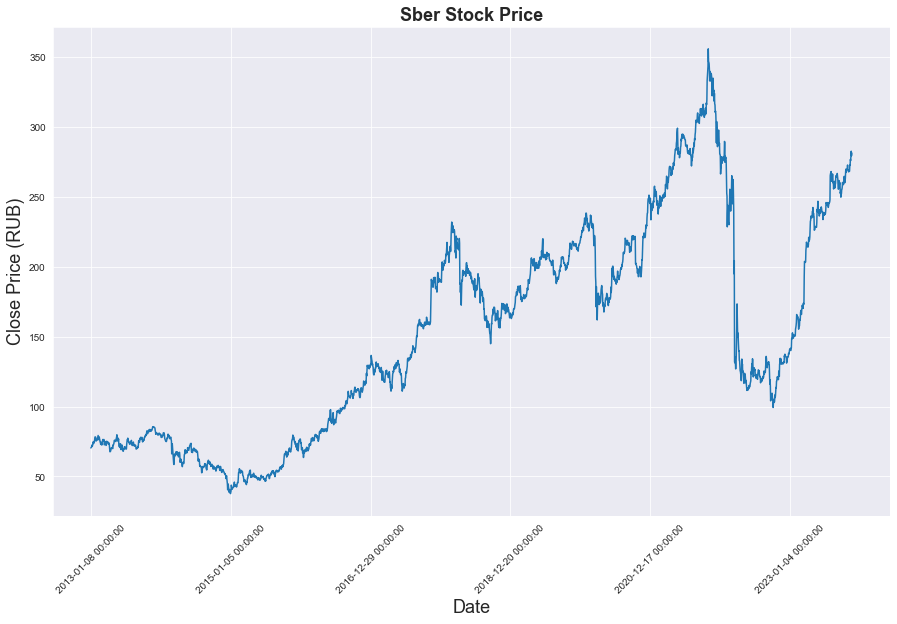

In [127]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[[sym]])
plt.xticks(range(0,data.shape[0],500),data['DATE'].loc[::500],rotation=45)
plt.title("Sber Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (RUB)',fontsize=18)
plt.show()

In [128]:
price = data[[sym]]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SBERP   2721 non-null   float64
dtypes: float64(1)
memory usage: 21.4 KB


In [129]:
from sklearn.preprocessing import MinMaxScaler
price = data[[sym]]
scaler = MinMaxScaler(feature_range=(-1, 1))
price[sym] = scaler.fit_transform(price[sym].values.reshape(-1,1))

In [130]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [131]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [132]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  torch.Size([2161, 19, 1])
y_train.shape =  (2161, 1)
x_test.shape =  torch.Size([540, 19, 1])
y_test.shape =  (540, 1)


In [133]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [134]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)#, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [135]:
model1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model1.parameters(), lr=0.01)

In [136]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model1(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.28976792097091675
Epoch  10 MSE:  0.045314181596040726
Epoch  20 MSE:  0.009148452430963516
Epoch  30 MSE:  0.0029753888957202435
Epoch  40 MSE:  0.0017513036727905273
Epoch  50 MSE:  0.0010440823389217257
Epoch  60 MSE:  0.0008777180919423699
Epoch  70 MSE:  0.0007283792365342379
Epoch  80 MSE:  0.0006793784559704363
Epoch  90 MSE:  0.0006604999070987105
Training time: 37.42952227592468


In [137]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

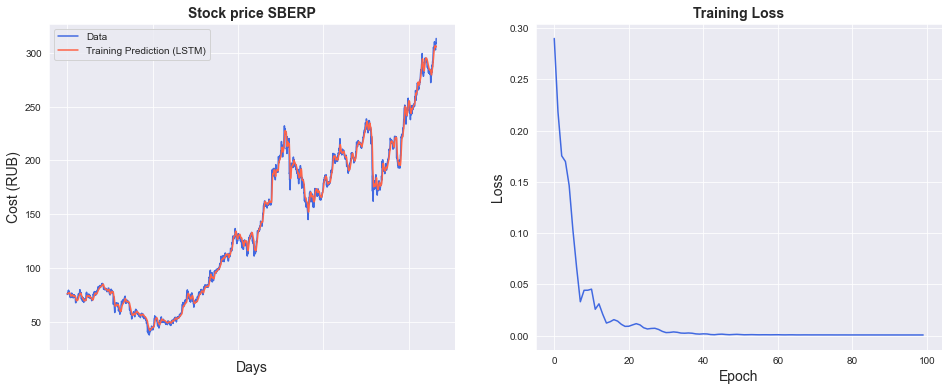

In [138]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title(f'Stock price {sym}', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (RUB)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [139]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model1(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 4.04 RMSE
Test Score: 9.91 RMSE


In [140]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price[sym].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [141]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text=f'Close (RUB) {sym}',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [142]:
# !pip install chart-studio

In [143]:
# import chart_studio.plotly as py
# import chart_studio

# chart_studio.tools.set_credentials_file(username='rodolfo_saldanha', api_key='zWJIVWJs23wfiAp516Mh')
# py.iplot(fig, filename='stock_prediction_lstm')

In [144]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)#, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [145]:
model2 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion1 = torch.nn.MSELoss(reduction='mean')
optimiser1 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [146]:
hist1 = np.zeros(num_epochs)
start_time1 = time.time()
gru = []
for t in range(num_epochs):
    y_train_pred = model2(x_train)
    loss1 = criterion1(y_train_pred, y_train_lstm)
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss1.item())
    hist1[t] = loss1.item()
    optimiser1.zero_grad()
    loss1.backward()
    optimiser1.step()
    
training_time1 = time.time()-start_time1
print("Training time: {}".format(training_time1))

Epoch  0 MSE:  0.21472851932048798
Epoch  10 MSE:  0.008547329343855381
Epoch  20 MSE:  0.006289868149906397
Epoch  30 MSE:  0.0022753551602363586
Epoch  40 MSE:  0.0007848927634768188
Epoch  50 MSE:  0.0004229445185046643
Epoch  60 MSE:  0.000438161485362798
Epoch  70 MSE:  0.00036105039180256426
Epoch  80 MSE:  0.00033316577901132405
Epoch  90 MSE:  0.00032729152007959783
Training time: 29.13599944114685


In [147]:
predict1 = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original1 = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

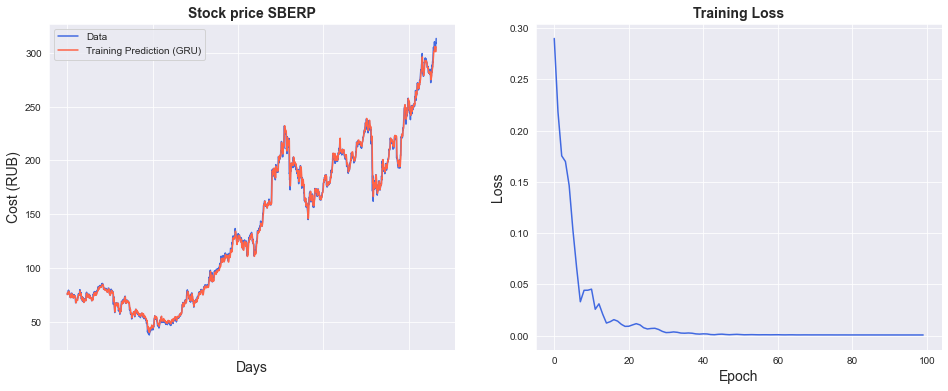

In [148]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original1.index, y = original1[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict1.index, y = predict1[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title(f'Stock price {sym}', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (RUB)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [149]:
# make predictions
y_test_pred = model2(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time1)

Train Score: 2.83 RMSE
Test Score: 6.42 RMSE


In [150]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price[sym].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [151]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text=f'Close (RUB) {sym}',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [152]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

LSTM        GRU
Train RMSE   4.040184   2.830113
Test RMSE    9.908469   6.424812
Train Time  37.429522  29.135999

In [153]:
# py.iplot(fig, filename='stock_prediction_gru')

In [154]:
pricess = df[sym][-lookback:]
pricess = scaler.fit_transform(pricess.values.reshape(-1,1))
pricess = np.array(pricess)
pricess = torch.from_numpy(pricess).type(torch.Tensor)
pricess = pricess.view((1, lookback, 1))
with torch.no_grad():
    p = model2(pricess).item()

p = scaler.inverse_transform(np.array(p).reshape(-1,1))[0][0]

print('Прогноз СБЕР на', date.today(), '= ', round(p,3))

Прогноз СБЕР на 2023-11-16 =  280.728


# Pytorch CLOSE price ver_2

https://evogeek.ru/articles/700475/

In [155]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm

In [180]:
# Sequence length of input
WINDOW_SIZE = 30
# Number of hidden layer neurons in LSTM
HIDDEN_SIZE = 256
# Number of LSTMs
NUM_LSTMS = 2

BATCH_SIZE = 128
EPOCHS = 20

In [181]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE 

'cpu'

In [182]:
df = pd.read_csv('stock_day.csv')
df

DATE    GAZP    ROSN   SBERP  RTKMP    MOEX
0     2013-01-08  147.90  268.98   70.38  92.50     NaN
1     2013-01-09  148.91  268.99   70.69  92.03     NaN
2     2013-01-10  147.60  266.65   70.90  91.00     NaN
3     2013-01-11  147.97  265.28   71.32  90.01     NaN
4     2013-01-14  149.60  267.00   72.47  90.56     NaN
...          ...     ...     ...     ...    ...     ...
2716  2023-11-09  168.16  583.10  276.05  74.10  205.11
2717  2023-11-10  168.25  598.30  279.30  74.30  211.10
2718  2023-11-13  167.85  598.30  282.74  76.35  202.49
2719  2023-11-14  165.86  591.30  279.54  75.80  198.41
2720  2023-11-15  166.46  585.00  281.49  76.35  202.79

[2721 rows x 6 columns]

In [183]:
train_df = df[(df['DATE'] >= '2012-01-01') & 
              (df['DATE'] < '2023-01-01')]
test_df = df[(df['DATE'] >= '2023-01-01')]

In [184]:
train_series = train_df[sym].to_list()#[::-1]
train_time = train_df['DATE'].to_list()#[::-1]
train_time = [date.fromisoformat(time) for time in train_time]
test_series = test_df[sym].to_list()#[::-1]
test_time = test_df['DATE'].to_list()#[::-1]
test_time = [date.fromisoformat(time) for time in test_time]

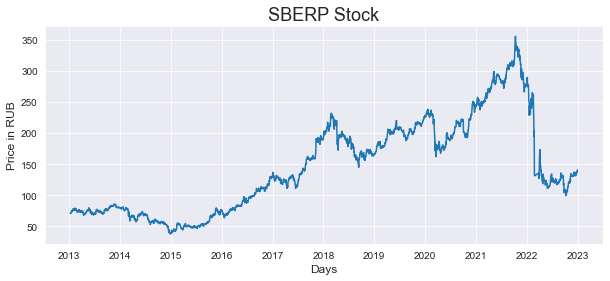

In [185]:
plt.figure(figsize=(10, 4))
plt.plot(train_time, train_series)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title(f'{sym} Stock', fontsize=18)
plt.show()

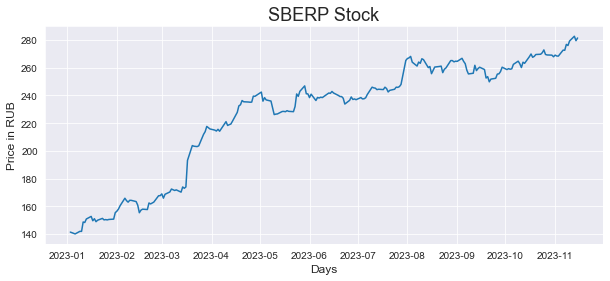

In [186]:
plt.figure(figsize=(10, 4))
plt.plot(test_time, test_series)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title(f'{sym} Stock', fontsize=18)
plt.show()


In [187]:
class SeriesDataset(Dataset):
                      def __init__(self, series, window_size):
                        self.series = series
                        self.window_size = window_size

                      def __len__(self):
                        return len(self.series) - self.window_size

                      def __getitem__(self, idx):
                        sequence = self.series[idx: idx + self.window_size]
                        label = self.series[idx + self.window_size]

                        return torch.tensor(sequence).unsqueeze(-1), torch.tensor(label).unsqueeze(-1)

In [188]:
train_dataset = SeriesDataset(train_series, WINDOW_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = SeriesDataset(test_series, WINDOW_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [189]:
class LSTM_Model(nn.Module):
                                  def __init__(self, hidden_size, num_layers):
                                    super(LSTM_Model, self).__init__()

                                    self.relu = nn.ReLU()

                                    self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size,
                                                        num_layers=num_layers, batch_first=True)

                                    self.fc1 = nn.Linear(hidden_size, 64)
                                    self.fc2 = nn.Linear(64, 1)


                                  def forward(self, x):
                                    x, _ = self.lstm(x)
                                    x = x[:, -1]
                                    x = self.fc1(x)
                                    x = self.relu(x)
                                    x = self.fc2(x)
                                    return x

In [190]:
model = LSTM_Model(HIDDEN_SIZE, NUM_LSTMS)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters())
loss_function = nn.L1Loss()

In [191]:
for epoch in range(EPOCHS):
          loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', colour='green')
          for sequence, label in loop:
            sequence = sequence.to(DEVICE)
            label = label.to(DEVICE)

            output = model(sequence)
            loss = loss_function(label, output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix({'L1 Loss': loss.item()})

Epoch 20/20: 100%|███████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s, L1 Loss=3.14]


In [192]:
predictions = []
model.eval()

loop = tqdm(test_dataloader, colour='green')
for sequence, label in loop:
                  sequence = sequence.to(DEVICE)
                  label = label.to(DEVICE)

                  output = model(sequence)

                  for val in output:
                    predictions.append(val.item())

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.38it/s]


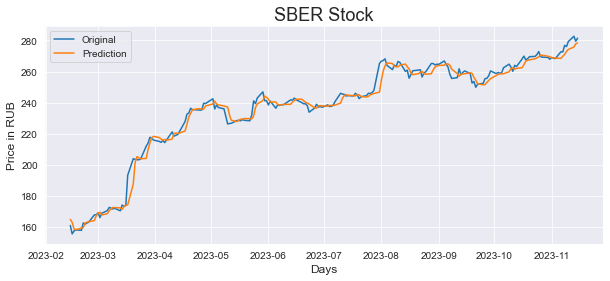

In [193]:
plt.figure(figsize=(10, 4))
plt.plot(test_time[WINDOW_SIZE:], test_series[WINDOW_SIZE:], label='Original')
plt.plot(test_time[WINDOW_SIZE:], predictions, label='Prediction')
plt.legend()
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title('SBER Stock', fontsize=18)
plt.show()

In [194]:
torch.save(model.state_dict(), f"stock_model_{sym}.pt")

In [195]:
prices = df[sym].to_list()[-WINDOW_SIZE:]

In [196]:
prices = torch.tensor(prices)
prices = prices.view((1, WINDOW_SIZE, 1))

In [197]:
model = LSTM_Model(HIDDEN_SIZE, NUM_LSTMS)
model.load_state_dict(torch.load(f"stock_model_{sym}.pt", map_location=torch.device('cpu')))
model.eval()

LSTM_Model(
  (relu): ReLU()
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [198]:
with torch.no_grad():
    prediction = model(prices).item()

print('Прогноз СБЕР на', date.today(), '= ', round(prediction,3))

Прогноз СБЕР на 2023-11-16 =  279.006
